Harvard NLP 의 [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)를 구현하는 것을 목표로 해보자.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context='talk')
%matplotlib inline

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda')

# 모델 구조

<img src='./transformer.png'>

인코더와 디코더로 분리되어 있으며, 각각은 동일한 구조의 레이어를 여러번 반복 적용하는 형태로 이루어져 있다. 이 모델에서는 동일한 레이어를 반복하여 쌓는 일이 많으므로 다음 함수를 정의한다.

In [2]:
def clones(module, N):
    "N개의 동일한 레이어를 생성한다."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# Sublayer 정의

향후 인코더/디코더 정의에 필요한 layer normalization과 sublayer connection, feed-forward net, 그리고 self-attention을 구현한다.

### 1. Layer Normalization

뉴런 $x = (x_1, \ldots, x_m)$ 의 Layer normalization 은 다음과 같이 정의된다.

$$ \bar{x} =  \frac{a}{\sigma} ( x - \mu) + b.$$

여기서 $\mu = \frac1m \sum x_i, \sigma = \sqrt{\frac1m \sum(x_i - \mu)}$이며, $a, b$는 학습되는 값이다.

In [3]:
class LayerNorm(nn.Module):
    "Layer normalization 계층을 구성한다."
    def __init__(self, size, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(size))
        self.b_2 = nn.Parameter(torch.zeros(size))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x-mean) / (std+self.eps) + self.b_2

### 2. Sublayer Connection

임의의 sublayer에 residual connection과 layer normalization, dropout을 적용한다.

In [4]:
class SublayerConnection(nn.Module):
    """
    임의의 sublayer에 대해 residual connection과 layer normalization을 적용한다.
    이때 드랍아웃 또한 적용하여 오버피팅을 방지한다.
    구현의 편의를 위해 normalization은 입력에서 적용한다.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        # 입력으로 x 뿐 아니라 sublayer를 받아야함!
        return x + self.dropout(sublayer(self.norm(x)))

### 3. Feed-forward net

토큰 단위로 FFN을 적용하는 Positionwise FFN 을 정의한다.

In [5]:
class PositionwiseFeedForward(nn.Module):
    """
    FFN 구현. d_model 차원의 입력값을 d_ff 차원의 공간에 임베딩한 후 
    relu 함수를 취한 후 다시 d_model 차원으로 임베딩한다.
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

### 4. Multi-head Attention

먼저, 쿼리(Q), 키(K), 값(V)를 입력으로 받아서 아래 그림처럼 연산을 처리하는 atttention 함수를 구현한다. 이때 scale 과정은 $\sqrt{d_k}$로 나눠주는 것이다.

<img src=./attention.png>

In [6]:
def attention(query, key, value, mask=None, dropout=None):
    "Scaled Dot Product Attention을 구현한다."
    d_k = query.size(-1) # query size = (length, d_k)
    scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(d_k)
    # scores size = (length, length)
    if mask is not None:
        # 마스크가 False(=0)인 점은 -10^9 로 채워 학습되는 것을 방지
        scores = scores.masked_fill(mask ==0 , -1e9) 
    p_attn = F.softmax(scores, dim = -1)
    # p_attn size = (length)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn
    # return size = (length, d_k)

이렇게 정의된 attention 함수를 여러개 쌓아올린 multi-head attention 을 구현한다.

<img src=./multi-head_attention.png width=250>

In [7]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "h : head 갯수, d_model : 모델 차원."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0 # 입력 벡터를 h개로 나눠야하므로 체크 필요
        self.d_k = d_model // h # 정수로 처리하기 위해 // 사용
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        # 위 그림에 linear module이 4개 필요
        self.attn = None 
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # 마스크를 모든 head에 동일하게 적용한다.
            mask = mask.unsqueeze(1) # 마스크 벡터의 head 부분에 해당하는 값을 1로 채움
        nbatches = query.size(0) # query size : (nbatches, length, d_model)
        
        # 1) Q, K, V 에 linear projection을 취한 후 사이즈 변환 => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
            for l, x in zip(self.linears, (query, key, value))]
        # size : (nbatches, h, length, d_k)
        
        # 2) (length, d_k) 사이즈의 벡터들에 attention을 h번 적용
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # x size : (nbatches, h, length, d_k)
        
        # 3) x를 이어붙인 후 마지막 linear projection 적용
        x = x.transpose(1,2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x) # size : (nbatches, length, d_model)

# 인코더

<img src='./transformer.png'>

인코더는 $N=6$개의 인코더 레이어를 쌓아서 만든다. 따라서 인코더 레이어(layer)와 $N$을 초기값으로 받으며, 입력값을 각 인코더 레이어에 반복 적용한 값을 출력한다.

In [8]:
class Encoder(nn.Module):
    "인코더는 N개의 레이어로 구성된다."
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "입력값(과 마스크)를 각각의 레이어에 통과시킨다."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## 인코더 레이어

인코더에서 반복 적용되는 레이어를 정의한다.

In [9]:
class EncoderLayer(nn.Module):
    "인코더 레이어는 셀프어텐션과 FFN으로 이루어져 있다."
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        """
        sublayer는 입력값 x뿐 아니라 적용할 layer도 입력으로 받아야함.
        sublayer[0]은 self_attn, sublayer[1]은 FFN을 적용 layer로 사용한다.
        """
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) 
        # 입력값도 패딩으로 인한 마스킹 필요
        return self.sublayer[1](x, self.feed_forward)

# 디코더

인코더와 동일하게 $N=6$개의 디코더 레이어를 쌓아서 구성한다.

In [10]:
class Decoder(nn.Module):
    "N개의 디코더 레이어로 구성"
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        "memory는 인코더의 출력값으로, 디코더 레이어의 두번째 self_attn의 입력에 사용"
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

# 디코더 레이어

인코더에 비해 디코더는 하나의 서브레이어가 더 필요하며, 여기서는 인코더의 아웃풋을 받아서 멀티헤드 셀프어텐션을 수행한다.

In [11]:
class DecoderLayer(nn.Module):
    "셀프어텐션, 소스어텐션, FFN으로 구성한다."
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn # 입력값을 연산
        self.src_attn = src_attn # 쿼리는 입력값, 키와 밸류는 인코더의 출력값을 입력
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        sublayer[0]은 self_attn, sublayer[1]은 src_attn,
        sublayer[2]는 FFN을 적용 layer로 사용한다. 
        """
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x,tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x,m,m,src_mask))
        return self.sublayer[2](x, self.feed_forward)

# 마스킹

디코더 레이어의 셀프어텐션이 현재의 입력값 이후의 값을 참조하지 못하도록 마스킹이 필요하다. 다시 말해, $i$번째 위치의 값을 예측하는데에는 $i$보다 앞에 나오는 단어들만 참조하도록 구성해야 한다.

In [12]:
def subsequent_mask(size):
    "마스킹 생성"
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0 # 대각선 아래만 True, 위에는 False

#### numpy.triu($m, k=0$)
Upper triangle of an array. Return a copy of a matrix with the elements below the $k$-th diagonal zeroed.

In [13]:
print(np.triu(np.ones([4,4]), k=1))
print(np.triu(np.ones([4,4]), k=0))

[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
[[1. 1. 1. 1.]
 [0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]]


In [14]:
subsequent_mask(5)

tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])

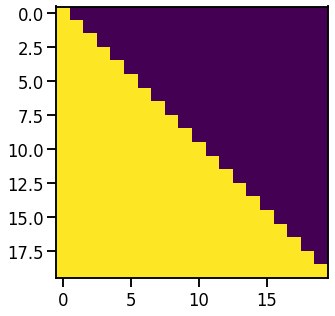

In [15]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
plt.show()
# 각각의 타겟 단어(행)가 참조할 수 있는 범위(열)을 보여준다.

# 임베딩

### 1. 임베딩 레이어

입력과 출력 언어의 단어를 공유하는 하나의 Embedding을 생성한다. 이때, weight에 $\sqrt{d_{model}}$을 곱하여 생성한다.

In [16]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

### 2. Positional Encoding

$$
\text{PE}_{(pos,2i)} = \sin(pos/10000^{2i/{d_{model}}}) \\
\text{PE}_{(pos,2i+1)} = \cos(pos/10000^{2i/{d_{model}}})
$$

In [17]:
class PositionalEncoding(nn.Module):
    "입력값에 PE를 더하는 모듈 구성."
    def __init__(self, d_model, dropout, max_len=5000, dev=dev):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        self.pe = torch.zeros([max_len, d_model],requires_grad=False).to(dev)
        position = torch.arange(0, max_len).unsqueeze(1) # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                            - (math.log(10000.0) / d_model)) # (d_model/2)
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = (self.pe).unsqueeze(0) # (1, max_len, d_model)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)] # x의 length까지만 필요함
        return self.dropout(x)

# 모델 정의

위에서 주어진 레이어들을 토대로 실제 모델을 정의하자. 먼저 인코더와 디코더로 구성되는 모델의 기본 구조 밑 단어 생성자를 구현한다.

In [18]:
class EncoderDecoder(nn.Module):
    """
    표준적인 인코더-디코더 모델 구현
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    
    def encode(self, src, src_mask):
        "입력값(단어 index)을 받아서 인코딩"
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        "결과값(index)과 인코더의 어텐션의 출력을 받아서 디코딩"
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "인코더의 출력값을 메모리 입력값으로 받아서 순전파"
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [19]:
class Generator(nn.Module):
    "일반적인 linear + softmax 계층 구현."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        # 벡터를 단어로 변환
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

위에서 정의한 레이어들을 이용하여 드디어 모델 구현...

<img src=./transformer.png>

In [20]:
def make_model(src_vocab, tgt_vocab, N=4,
               d_model=256, d_ff=1024, h=4, dropout=0.1):
    "하이퍼파라미터들로부터 모델 생성"
    c = copy.deepcopy # 클래스 생성 후 deepcopy하여 사용
    
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout),N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [21]:
tmp_model = make_model(10,10, 2)

# 훈련

## 배치와 마스킹 생성

In [22]:
class Batch:
    "트레이닝 배치를 받아서 마스킹과 디코더의 입력/출력 분해 구현."
    def __init__(self, src, trg=None, pad=0, dev=dev):
        self.src = src.to(dev)
        self.src_mask = (src != pad).unsqueeze(-2).to(dev) # 패딩(0) 외에는 True
        self.dev = dev
        if trg is not None:
            self.trg = trg[:, :-1] # 마지막 단어는 디코더의 입력으로 넣지 않음
            self.trg_y = trg[:, 1:] # 디코더의 결과값의 ground truth
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum() 
            
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2).to(dev) # 패딩 외에는 True
        tgt_mask = (tgt_mask & subsequent_mask(tgt.size(-1)).to(dev)).type_as(tgt_mask.data)
        return tgt_mask

## Optimizer

아담 옵티마이저를 $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$ 옵션으로 구현한다. 그리고 warmup step을 4000으로 하여 warm start를 구현한다.

In [23]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step=None):
        "Implement 'lrate'"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * 
                             min(step**(-0.5), step * self.warmup**(-1.5)))
    
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000, 
                  torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

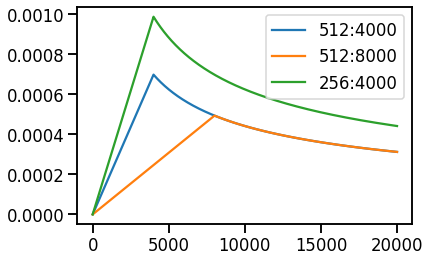

In [24]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## 데이터 생성

In [25]:
# For data loading.
from torchtext import data, datasets

import spacy
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                 eos_token = EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN = 100
train, val, test = datasets.IWSLT.splits(
    exts=('.de', '.en'), fields=(SRC, TGT), 
    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
        len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 2
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

In [26]:
len(SRC.vocab), len(TGT.vocab)

(58790, 36323)

In [32]:
from torchtext.data import Iterator

train_loader = Iterator(train, 
                        batch_size=32, 
                        device=dev,#torch.device('cpu'),  
                        repeat=True)

# 모델 훈련 구현

In [33]:
def run_epoch(data_iter, model, optim, optim_rate, loss_compute, epoch_num):
    "일반적인 훈련 모델 구현"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, data in enumerate(data_iter):
        batch = Batch(data.src.transpose(0,1), data.trg.transpose(0,1))
        #out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        out = model(batch.src.to(dev), batch.trg.to(dev), batch.src_mask.to(dev), batch.trg_mask.to(dev))
        res = model.generator(out)
#         print('out size : {}, res size : {}, batch.trg_y size : {}'.
#               format(out.size(), res.size(), batch.trg_y.size()))
        optim.zero_grad()
        loss = loss_compute(res.contiguous().view(-1,res.size(-1)), batch.trg_y.contiguous().view(-1))
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        loss.backward()
        optim_rate.step()
        if i % 1000 == 1:
            elapsed = time.time() - start
            print("Epoch: %d Step: %d Loss: %f Tokens per Sec: %f" %
                 (epoch_num, i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

# 모델 생성 후 훈련

In [29]:
model = make_model(len(SRC.vocab), len(TGT.vocab), N=4,
               d_model=256, d_ff=1024, h=4, dropout=0.1)
model.to(dev)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): Linear(in_features=256, out_features=256, bias=True)
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=256, out_features=1024, bias=True)
          (w_2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

In [30]:
loss_f = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
opt_rate = NoamOpt(model.src_embed[0].d_model, 2, 4000, opt)

In [34]:
epoch = 5
for i in range(epoch):
    run_epoch(train_loader, model, opt, opt_rate, loss_f, i+1)

RuntimeError: CUDA out of memory. Tried to allocate 330.00 MiB (GPU 0; 5.81 GiB total capacity; 4.63 GiB already allocated; 76.50 MiB free; 68.67 MiB cached)

In [ ]:
save_path = 'Transformer_epoch_{}.pt'.format(epoch)
torch.save(model.state_dict(), save_path)

In [ ]:
path = 'Transformer_epoch_3.pt'
model2 = make_model(len(SRC.vocab), len(TGT.vocab), N=4,
               d_model=256, d_ff=1024, h=4, dropout=0.1)
model2.to(dev)
model2.load_state_dict(torch.load(path))
model2.eval()